# Vanilla GAN
```GAN 01 - Vanilla, 28x28 output```

Used PR Castro's code for reference: https://github.com/prcastro/pytorch-gan

### Importing libraries and dataset

In [1]:
# import the dataset class
import dataset01 as dataset

# python imports
import itertools
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

# pytorch imports
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
# This opens the HDF5 database and allows us to query it
data = dataset.get_dataset()
print("there are", len(data), "images in this dataset")

there are 30650 images in this dataset


### Creating a dataloader 

In [3]:
# Setting threads (num_workers) to 0 as suggested at https://discuss.pytorch.org/t/dataloader-iteration-hang-up/12886/3
threads = 0 # can increase this to have more data preloading, useful if your CPU cant keep up with GPU
batchSize = 100 
shuffle = True # Shuffle the dataset before loading batches, set to True during training
cuda = True 

train_loader = DataLoader(dataset=data, num_workers=threads, batch_size=batchSize, shuffle=shuffle, pin_memory=cuda)
print('There are ' + str(len(train_loader)) + ' batches')

There are 307 batches


### Model set-up

In [4]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [5]:
# Generator model
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [6]:
# Move them to GPU
discriminator = Discriminator().cuda()
generator = Generator().cuda()

### Optimization

In [7]:
# Binary Cross Entropy loss
criterion = nn.BCELoss()

lr = 0.0002 # learning rate
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

### Training

In [8]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [9]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [10]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
fix_noise = Variable(torch.randn(num_test_samples, 100).cuda())

### Execute training and sampling

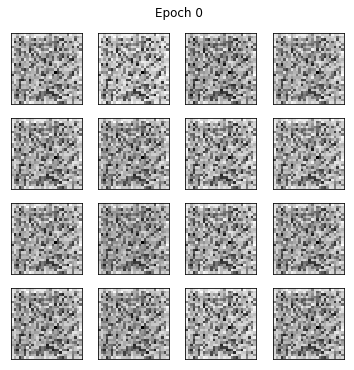

Epoch [1/200], Step[100/307], d_loss: 0.7411, g_loss: 2.7827, D(x): 0.75, D(G(z)): 0.35


KeyboardInterrupt: 

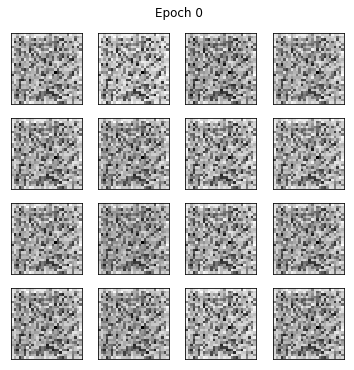

In [11]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)


# set number of epochs
num_epochs = 200
num_batches = len(train_loader)

for epoch in range(num_epochs):
    print('Working on epoch ' + str(epoch) + ' ...')
    for n, (images, letters, countries, cities, names) in enumerate(train_loader):
        images = Variable(images.cuda())
        real_labels = Variable(torch.ones(images.size(0)).cuda())
        
        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100).cuda())
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)).cuda())
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100).cuda())
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        
        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
        if (n+1) % 100 == 0:
            test_images = generator(fix_noise)
            
            # Diplay the images
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='gray')
            display.clear_output(wait=True)
            plt.title("Epoch " + str(epoch), y=4.75, x=-1.325)
            display.display(plt.gcf())
            
            # Save the image
            plt.savefig('Z:/GAN-Training-Results/MNISTGAN_28x28_v2/result_' + str(epoch) + '.png')
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))